<span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Feature Backfill for Air Quality Data</span>


## 🗒️ You have the following tasks
1. Choose an Air Quality Sensor
2. Update the country, city, and street information to point to YOUR chosen Air Quality Sensor
3. Download historical measures for your Air Quality Sensor as a CSV file
4. Update the path of the CSV file in this notebook to point to the one that you downloaded
5. Create an account on www.hopsworks.ai and get your HOPSWORKS_API_KEY
6. Run this notebook



### <span style='color:#ff5f27'> 📝 Imports

In [70]:
import datetime
import requests
import pandas as pd
import hopsworks
import datetime
from pathlib import Path
from functions import util
import json
import re
import os
import warnings
warnings.filterwarnings("ignore")

### IF YOU WANT TO WIPE OUT ALL OF YOUR FEATURES AND MODELS, run the cell below

In [ ]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# os.environ["HOPSWORKS_API_KEY"] = ""
# proj = hopsworks.login()
# util.purge_project(proj)

---

In [89]:
csv_file="../../data/bikes_oct.csv"
util.check_file_path(csv_file)

File successfully found at the path: ../../data/bikes_oct.csv


In [72]:
station_id =42

bikes_url = 'https://opendata-ajuntament.barcelona.cat/data/dataset/estat-estacions-bicing/resource/1b215493-9e63-4a12-8980-2d7e0fa19f85/download/recurs.json'

# Station 42 latitude and longitude
latitude = "41.404511"
longitude = "2.189881"

today = datetime.date.today()

## <span style='color:#ff5f27'> 🌍 STEP 4: Get a Bareclona BICING API Token and Store it as a Secret in Hopsworks </span>

You have to first get your AQI API key [from here](https://aqicn.org/data-platform/token/):

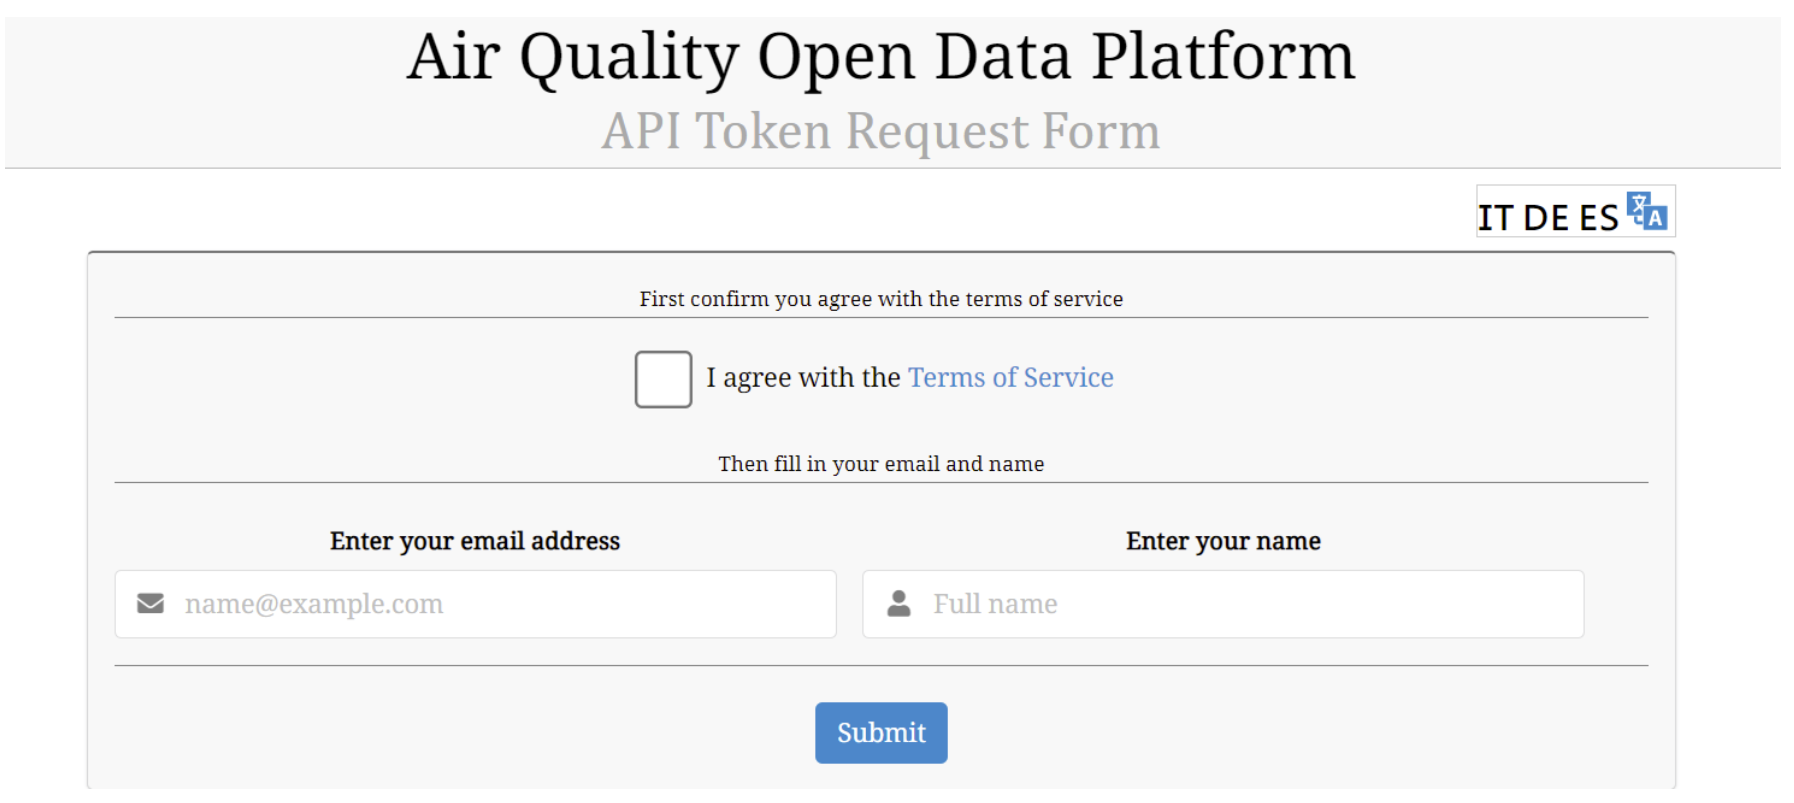


Save the API KEY to a new file you need to create in your repository (do not check this file into Github!):

 * <project root>/data/aqi-api-key.txt

In [73]:
bicing_api_key_file = '../../data/bicing-api-key.txt'
util.check_file_path(bicing_api_key_file)

with open(bicing_api_key_file, 'r') as file:
    BICING_API_KEY = file.read().rstrip()

File successfully found at the path: ../../data/bicing-api-key.txt


## Hopsworks API Key
You need to have registered an account on app.hopsworks.ai.
You will be prompted to enter your API key here, unless you set it as the environment variable HOPSWORKS_API_KEY (my preffered approach).

In [74]:
with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
    
project = hopsworks.login(project="juls_first_project")

2025-01-02 19:24:38,649 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-02 19:24:38,651 INFO: Initializing external client
2025-01-02 19:24:38,652 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-02 19:24:39,831 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164440


In [ ]:
secrets = hopsworks.get_secrets_api()
try:
    secrets.create_secret("BICING_API_KEY", BICING_API_KEY)
except hopsworks.RestAPIError:
    BICING_API_KEY = secrets.get_secret("BICING_API_KEY").value

'81ac9c0b4fbc715506b9717c74aa0aeb123f8e51a9b17ac777ae3a44bfd02d'

### Validate that the AQI_API_KEY you added earlier works

The cell below should print out something like:

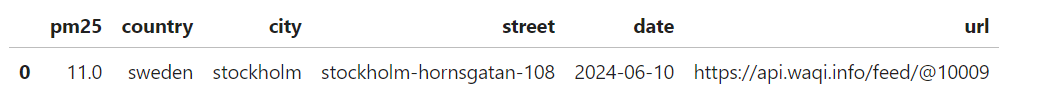

In [83]:
try:
    bikes_now_df = util.fetch_station_data(bikes_url, BICING_API_KEY, station_id)
except hopsworks.RestAPIError:
    print("It looks like the BICING_API_KEY doesn't work. Is the API key correct? Is the URL correct?")
bikes_now_df.head()

,station_id,num_bikes_available,last_reported
0,42,18,2025-01-02 18:25:03 UTC


## <span style='color:#ff5f27'> 🌍 STEP 5: Read your CSV file into a DataFrame </span>

The cell below will read up historical air quality data as a CSV file into a Pandas DataFrame

In [111]:
#get only the station_id=42 from the csv file
df = pd.read_csv(csv_file,  parse_dates=['last_updated'] , skipinitialspace=True)
df = df[df['station_id'] == station_id]
df.head(100)

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl,V1
39,42.0,1.0,0.0,1.0,21.0,1.727733e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1727733600,0.0,NaN
552,42.0,0.0,0.0,0.0,22.0,1.727734e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1727733901,0.0,NaN
1064,42.0,0.0,0.0,0.0,22.0,1.727734e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1727734198,0.0,NaN
1576,42.0,0.0,0.0,0.0,22.0,1.727734e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1727734501,0.0,NaN
2088,42.0,0.0,0.0,0.0,22.0,1.727735e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1727734804,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48754,42.0,20.0,3.0,17.0,1.0,1.727762e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1727762104,1.0,NaN
49267,42.0,21.0,4.0,17.0,1.0,1.727762e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1727762400,0.0,NaN
49780,42.0,21.0,5.0,16.0,1.0,1.727763e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1727762704,1.0,NaN
50293,42.0,21.0,6.0,15.0,1.0,1.727763e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1727763002,0.0,NaN


## <span style='color:#ff5f27'> 🌍 STEP 6: Data cleaning</span>


### Rename columns if needed and drop unneccessary columns

We want to have a DataFrame with 2 columns - `date` and `pm25` after this cell below:

## Check the data types for the columns in your DataFrame

 * `date` should be of type   datetime64[ns] 
 * `pm25` should be of type float64

In [ ]:
# These commands will succeed if your CSV file didn't have a `median` or `timestamp` column
#df = df.rename(columns={"median": "pm25"})
#df = df.rename(columns={"timestamp": "date"})

station_df = df[['last_updated', 'num_bikes_available']]
station_df['last_updated'] = pd.to_datetime(
    station_df['last_updated'], unit='s', utc=True, errors='coerce'
)
# Format the datetime to the desired string format
station_df['last_updated'] = station_df['last_updated'].apply(
    lambda x: x.strftime('%Y-%m-%d %H:%M:%S UTC') if pd.notnull(x) else 'Invalid Date'
)
station_df

,last_updated,num_bikes_available
39,2024-09-30 22:00:32 UTC,1.0
552,2024-09-30 22:04:48 UTC,0.0
1064,2024-09-30 22:09:04 UTC,0.0
1576,2024-09-30 22:15:28 UTC,0.0
2088,2024-09-30 22:19:44 UTC,0.0
...,...,...
4431815,2024-10-31 22:56:00 UTC,21.0
4432326,2024-10-31 23:00:16 UTC,21.0
4432837,2024-10-31 23:04:32 UTC,19.0
4433348,2024-10-31 23:10:56 UTC,19.0


In [115]:
# Cast the pm25 column to be a float32 data type
station_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8630 entries, 39 to 4433859
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   last_updated         8630 non-null   object 
 1   num_bikes_available  8630 non-null   float64
dtypes: float64(1), object(1)
memory usage: 202.3+ KB


## <span style='color:#ff5f27'> 🌍 STEP 7: Drop any rows with missing data </span>
It will make the model training easier if there is no missing data in the rows, so we drop any rows with missing data.

In [116]:
station_df.dropna(inplace=True)
station_df

,last_updated,num_bikes_available
39,2024-09-30 22:00:32 UTC,1.0
552,2024-09-30 22:04:48 UTC,0.0
1064,2024-09-30 22:09:04 UTC,0.0
1576,2024-09-30 22:15:28 UTC,0.0
2088,2024-09-30 22:19:44 UTC,0.0
...,...,...
4431815,2024-10-31 22:56:00 UTC,21.0
4432326,2024-10-31 23:00:16 UTC,21.0
4432837,2024-10-31 23:04:32 UTC,19.0
4433348,2024-10-31 23:10:56 UTC,19.0


## <span style='color:#ff5f27'> 🌍 STEP 8: Add country, city, street, url to the DataFrame </span>

Your CSV file may have many other air quality measurement columns. We will only work with the `pm25` column.

We add the columns for the country, city, and street names that you changed for your Air Quality sensor.

We also want to make sure the `pm25` column is a float32 data type.

In [ ]:
# Your sensor may have columns we won't use, so only keep the date and pm25 columns
# If the column names in your DataFrame are different, rename your columns to `date` and `pm25`

#df_aq['country']=country
#df_aq['city']=city
#df_aq['street']=street
#df_aq['url']=aqicn_url
#df_aq


,date,pm25,country,city,street,url
0,2024-11-01,43.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
1,2024-11-02,51.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
2,2024-11-03,47.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
3,2024-11-04,45.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
4,2024-11-05,58.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
...,...,...,...,...,...,...
603,2023-03-27,44.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
604,2023-03-28,18.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
605,2023-03-29,22.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769
606,2023-03-30,30.0,ireland,ireland,lucan--co.-dublin,https://api.waqi.info/feed/@14769


---

## <span style='color:#ff5f27'> 🌦 Loading Weather Data from [Open Meteo](https://open-meteo.com/en/docs)

## <span style='color:#ff5f27'> 🌍 STEP 9: Download the Historical Weather Data </span>

https://open-meteo.com/en/docs/historical-weather-api#hourly=&daily=temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant

We will download the historical weather data for your `city` by first extracting the earliest date from your DataFrame containing the historical air quality measurements.

We will download all daily historical weather data measurements for your `city` from the earliest date in your air quality measurement DataFrame. It doesn't matter if there are missing days of air quality measurements. We can store all of the daily weather measurements, and when we build our training dataset, we will join up the air quality measurements for a given day to its weather features for that day. 

The weather features we will download are:

 * `temperature (average over the day)`
 * `precipitation (the total over the day)`
 * `wind speed (average over the day)`
 * `wind direction (the most dominant direction over the day)`


In [17]:
earliest_aq_date = pd.Series.min(df_aq['date'])
earliest_aq_date = earliest_aq_date.strftime('%Y-%m-%d')
earliest_aq_date

weather_df = util.get_historical_weather(city, earliest_aq_date, str(today), latitude, longitude)

Coordinates 53.32161331176758°N -6.501922607421875°E
Elevation 11.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [18]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 632 entries, 0 to 631
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         632 non-null    datetime64[ns]
 1   temperature_2m_mean          632 non-null    float32       
 2   precipitation_sum            632 non-null    float32       
 3   wind_speed_10m_max           632 non-null    float32       
 4   wind_direction_10m_dominant  632 non-null    float32       
 5   city                         632 non-null    object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 24.7+ KB


## <span style='color:#ff5f27'> 🌍 STEP 10: Define Data Validation Rules </span>

We will validate the air quality measurements (`pm25` values) before we write them to Hopsworks.

We define a data validation rule (an expectation in Great Expectations) that ensures that `pm25` values are not negative or above the max value available by the sensor.

We will attach this expectation to the air quality feature group, so that we validate the `pm25` data every time we write a DataFrame to the feature group. We want to prevent garbage-in, garbage-out.

In [19]:
import great_expectations as ge
aq_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="aq_expectation_suite"
)

aq_expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"pm25",
            "min_value":-0.1,
            "max_value":500.0,
            "strict_min":True
        }
    )
)

{"expectation_type": "expect_column_min_to_be_between", "kwargs": {"column": "pm25", "min_value": -0.1, "max_value": 500.0, "strict_min": true}, "meta": {}}

## Expectations for Weather Data
Here, we define an expectation for 2 columns in our weather DataFrame - `precipitation_sum` and `wind_speed_10m_max`, where we expect both values to be greater than zero, but less than 1000.

In [20]:
import great_expectations as ge
weather_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="weather_expectation_suite"
)

def expect_greater_than_zero(col):
    weather_expectation_suite.add_expectation(
        ge.core.ExpectationConfiguration(
            expectation_type="expect_column_min_to_be_between",
            kwargs={
                "column":col,
                "min_value":-0.1,
                "max_value":1000.0,
                "strict_min":True
            }
        )
    )
expect_greater_than_zero("precipitation_sum")
expect_greater_than_zero("wind_speed_10m_max")

---

### <span style="color:#ff5f27;"> 🔮 STEP 11: Connect to Hopsworks and save the sensor country, city, street names as a secret</span>

In [21]:
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.


#### Save country, city, street names as a secret

These will be downloaded from Hopsworks later in the (1) daily feature pipeline and (2) the daily batch inference pipeline

In [23]:
dict_obj = {
    "country": country,
    "city": city,
    "street": street,
    "aqicn_url": aqicn_url,
    "latitude": latitude,
    "longitude": longitude
}

# Convert the dictionary to a JSON string
str_dict = json.dumps(dict_obj)

try:
    secrets.create_secret("SENSOR_LOCATION_JSON", str_dict)
except hopsworks.RestAPIError:
    print("SENSOR_LOCATION_JSON already exists. To update, delete the secret in the UI (https://c.app.hopsworks.ai/account/secrets) and re-run this cell.")
    existing_key = secrets.get_secret("SENSOR_LOCATION_JSON").value
    print(f"{existing_key}")

Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets


### <span style="color:#ff5f27;"> 🔮 STEP 12: Create the Feature Groups and insert the DataFrames in them </span>

### <span style='color:#ff5f27'> 🌫 Air Quality Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each air quality sensor measurement is uniquely identified by `country`, `street`, and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [24]:
air_quality_fg = fs.get_or_create_feature_group(
    name='air_quality',
    description='Air Quality characteristics of each day',
    version=1,
    primary_key=['city', 'street', 'date'],
    event_time="date",
    expectation_suite=aq_expectation_suite
)

#### Insert the DataFrame into the Feature Group

In [25]:
air_quality_fg.insert(df_aq)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/1339753
2024-11-07 14:23:55,581 INFO: 	1 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/398/fs/335/fg/1339753


Uploading Dataframe: 0.00% |          | Rows 0/608 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/air_quality_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fbe5f2bb280>,
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "pm25",
           "min_value": -0.1,
           "max_value": 500.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 663562
         }
       },
       "result": {
         "observed_value": 3.0,
         "element_count": 608,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2024-11-07T01:23:55.000580Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     }
   ],
   "evaluation_parameters": {},
   "statistics": {
     "evaluated_expectations": 1,
     "successful_expectations": 1,
     "un

#### Enter a description for each feature in the Feature Group

In [26]:
air_quality_fg.update_feature_description("date", "Date of measurement of air quality")
air_quality_fg.update_feature_description("country", "Country where the air quality was measured (sometimes a city in acqcn.org)")
air_quality_fg.update_feature_description("city", "City where the air quality was measured")
air_quality_fg.update_feature_description("street", "Street in the city where the air quality was measured")
air_quality_fg.update_feature_description("pm25", "Particles less than 2.5 micrometers in diameter (fine particles) pose health risk")

### <span style='color:#ff5f27'> 🌦 Weather Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each weather measurement is uniquely identified by `city` and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [27]:
# Get or create feature group 
weather_fg = fs.get_or_create_feature_group(
    name='weather',
    description='Weather characteristics of each day',
    version=1,
    primary_key=['city', 'date'],
    event_time="date",
    expectation_suite=weather_expectation_suite
) 

#### Insert the DataFrame into the Feature Group

In [ ]:
# Insert data
weather_fg.insert(weather_df)

#### Enter a description for each feature in the Feature Group

In [ ]:
weather_fg.update_feature_description("date", "Date of measurement of weather")
weather_fg.update_feature_description("city", "City where weather is measured/forecast for")
weather_fg.update_feature_description("temperature_2m_mean", "Temperature in Celsius")
weather_fg.update_feature_description("precipitation_sum", "Precipitation (rain/snow) in mm")
weather_fg.update_feature_description("wind_speed_10m_max", "Wind speed at 10m abouve ground")
weather_fg.update_feature_description("wind_direction_10m_dominant", "Dominant Wind direction over the dayd")

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02: Daily Feature Pipeline 
 </span> 


## <span style="color:#ff5f27;">⏭️ **Exercises:** 
 </span> 

Extra Homework:

  * Try adding a new feature based on a rolling window of 3 days for 'pm25'
      * This is not easy, as forecasting more than 1 day in the future, you won't have the previous 3 days of pm25 measurements.
      * df.set_index("date").rolling(3).mean() is only the start....
  * Parameterize the notebook, so that you can provide the `country`/`street`/`city`/`url`/`csv_file` as parameters. 
      * Hint: this will also require making the secret name (`SENSOR_LOCATION_JSON`), e.g., add the street name as part of the secret name. Then you have to pass that secret name as a parameter when running the operational feature pipeline and batch inference pipelines.
      * After you have done this, collect the street/city/url/csv files for all the sensors in your city or region and you make dashboards for all of the air quality sensors in your city/region. You could even then add a dashboard for your city/region, as done [here for Poland](https://github.com/erno98/ID2223).

Improve this AI System
  * As of mid 2024, there is no API call available to download historical data from the AQIN website. You could improve this system by writing a PR to download the CSV file using Python Selenium and the URL for the sensor.


---